In [1]:
import numpy as np
import pandas as pd


import os
import boto3

import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql.functions import monotonically_increasing_id, pandas_udf, PandasUDFType, col

import IPython.display as dp

In [2]:
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array

keras.backend.set_image_data_format('channels_last')

2022-11-18 18:12:25.061012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 18:12:25.196721: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-18 18:12:25.196741: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-18 18:12:25.232698: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-18 18:12:25.975396: W tensorflow/stream_executor/platform/de

In [3]:
print("Pyspark : ", pyspark.__version__)
print("Numpy : ", np.__version__)
print("Keras : ", keras.__version__)

Pyspark :  3.3.1
Numpy :  1.21.6
Keras :  2.10.0


# Building pyspark session

In [4]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-hadoop-cloud_2.12:3.2.0 pyspark-shell'

In [5]:
spark = SparkSession \
    .builder \
    .appName('FeatureExtractPreprocess') \
    .config('spark.driver.memory', '12g') \
    .config('spark.driver.cores', '4') \
    .config('spark.executor.memory', '4g') \
    .getOrCreate()

spark

:: loading settings :: url = jar:file:/home/ubuntu/anaconda3/envs/project8/lib/python3.7/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
org.apache.spark#spark-hadoop-cloud_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-511e07e5-93b7-45a2-ad61-0d6f23fb6f2f;1.0
	confs: [default]
	found org.apache.spark#spark-hadoop-cloud_2.12;3.2.0 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.1 in central
	found org.apache.hadoop#hadoop-client-api;3.3.1 in central
	found org.apache.htrace#htrace-core4;4.1.0-incubating in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.hadoop#hadoop-aws;3.3.1 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.901 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found org.apache.hadoop#hadoop-openstack;3.3.1 in central
	found org.apache.hadoop#hadoop-annotations;3.3.1

22/11/18 18:12:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# Test connection to the S3 bucket and that the data are correclty loaded

In [6]:
bucket = 'oc8try' # Bucket name
subfolder = 'Data'

conn = boto3.client('s3')

data = conn.list_objects(Bucket=bucket, Prefix=subfolder)['Contents']

for i in data[:20]:
    print(i['Key'])

Data/Banana/0_100.jpg
Data/Banana/104_100.jpg
Data/Banana/107_100.jpg
Data/Banana/10_100.jpg
Data/Banana/112_100.jpg
Data/Banana/117_100.jpg
Data/Banana/118_100.jpg
Data/Banana/119_100.jpg
Data/Banana/11_100.jpg
Data/Banana/120_100.jpg
Data/Banana/121_100.jpg
Data/Banana/122_100.jpg
Data/Banana/123_100.jpg
Data/Banana/124_100.jpg
Data/Banana/125_100.jpg
Data/Banana/126_100.jpg
Data/Banana/127_100.jpg
Data/Banana/128_100.jpg
Data/Banana/129_100.jpg
Data/Banana/130_100.jpg


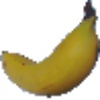

In [7]:
dp.display_jpeg(conn.get_object(Bucket=bucket, Key=data[0]['Key'])['Body'].read(), raw=True)

# Load data
### Raw data

In [8]:
data = spark.read.format('image') \
    .option('pathGlobFilter', '*.jpg') \
    .option('recursiveFileLookup', 'true') \
    .load('s3a://oc8try/Data_subsample')

data.persist()

data.printSchema()

22/11/18 18:12:36 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [9]:
data.count()

50

### Put raw data into spark dataframes

In [10]:
from pyspark.sql.functions import monotonically_increasing_id

#LABELS
data_labels = data.select('image.origin').rdd.map(
        lambda x: x.origin.split('/')[-2].replace('.jpg', '')
    )
data_labels.persist()
data_labels = data_labels.map(
        lambda x: pyspark.sql.Row(label=x)
    ).toDF().withColumn('id', monotonically_increasing_id())

#FILENAMES
data_filenames = data.select('image.origin').rdd.map(
        lambda x: x.origin.split('Data_subsample/')[-1].replace('.jpg', '')
    )
data_filenames.persist()
data_filenames = data_filenames.map(
        lambda x: pyspark.sql.Row(filename=x)
    ).toDF().withColumn('id', monotonically_increasing_id())

#PIXEL VALUES TO MATRIX
data_values = data.select('image.data').rdd.map(
        lambda x: np.reshape(x.data, [100, 100, 3]).tolist()
    )
data_values.persist()    
data_values = data_values.map(
        lambda x: pyspark.sql.Row(values=x)
    ).toDF()


# Create and setup VGG16 model
#### This model allows for a first dimensionality reduction as we start from 100x100x3 values and end up with 4608 values

In [11]:
from keras.layers import Flatten

model = VGG16(weights="imagenet", include_top=False, input_shape=(100, 100, 3))
model = Model(inputs=model.inputs, outputs=Flatten()(model.output))
for layer in model.layers:
    layer.trainable=False

model.summary()

2022-11-18 18:12:44.185404: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-18 18:12:44.185439: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-18 18:12:44.185461: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-38-66): /proc/driver/nvidia/version does not exist
2022-11-18 18:12:44.185717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

### Feature extraction from raw data, stored in spark dataframe

In [12]:
def featurize(image):
    values_tensor = tf.convert_to_tensor(image.tolist())
    return pd.Series(model.predict(values_tensor).tolist())

featurize_udf = pandas_udf(featurize, ArrayType(FloatType()))

features = data_values.select(featurize_udf(data_values.values).alias('features')).withColumn('id', monotonically_increasing_id())

features.persist()
data.unpersist()

INFO:tensorflow:Assets written to: ram://8bbbf480-7dff-4141-ab94-ff66747fab61/assets


INFO:tensorflow:Assets written to: ram://8bbbf480-7dff-4141-ab94-ff66747fab61/assets


DataFrame[image: struct<origin:string,height:int,width:int,nChannels:int,mode:int,data:binary>]

## Split features list to several columns (1 column per feature)

In [13]:
import pyspark.sql.functions as F

nb_features = len(features.select('features').collect()[0][0])
features = features.select([F.col('features')[i] for i in range(nb_features)]).withColumn('id', monotonically_increasing_id())

2022-11-18 18:12:49.686636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 18:12:49.714924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 18:12:49.797369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [14]:
len(features.columns)

4609

### Join dataframe with labels, file names and extracted features, export to the S3 bucket as .csv file

In [15]:
df_join = data_labels.join(data_filenames, on='id')
df_join = df_join.join(features, on='id')

df_join.write.csv('s3a://oc8try/preprocessing/preprocessed_features.csv', mode='overwrite')

#features.unpersist()    # Uncomment if no PCA

22/11/18 18:13:24 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/11/18 18:13:25 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


22/11/18 18:13:32 WARN DAGScheduler: Broadcasting large task binary with size 1966.5 KiB


22/11/18 18:13:35 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


# Optional: 2nd dimensionality reduction (PCA)

In [16]:
from pyspark.ml.feature import StandardScaler, VectorAssembler, PCA
from pyspark.ml.functions import array_to_vector
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf
from pyspark.ml import Pipeline

In [17]:
list_feat = [col for col in features.columns if 'features' in col]
    
assembler = VectorAssembler(inputCols=list_feat, outputCol='vect_features') # assemble feature columns to vector
scaler = StandardScaler(inputCol='vect_features', outputCol='scaled_features') # scale feature vector
pca = PCA(k=2, inputCol='scaled_features', outputCol='pca_features') # pca on scaled features

pipeline = Pipeline(stages=[assembler, scaler, pca])

features = pipeline.fit(features).transform(features).drop(*list_feat).drop(*['vect_features', 'scaled_features'])

features.show(5)

22/11/18 18:14:04 ERROR CodeGenerator: failed to compile: org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "processNext()V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1" grows beyond 64 KB
org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "processNext()V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1" grows beyond 64 KB
	at org.codehaus.janino.UnitCompiler.compile2(UnitCompiler.java:366)
	at org.codehaus.janino.UnitCompiler.access$000(UnitCompiler.java:226)
	at org.codehaus.janino.UnitCompiler$1.visitCompilationUnit(UnitCompiler.java:336)
	at org.codehaus.janino.UnitCompiler$1.visitCompilationUnit(UnitCompiler.java:333)
	at org.codehaus.janino.Java$CompilationUnit.accept(Java.java:363)
	at org.codehaus.janino.UnitCompiler.compileUnit(UnitCompiler.java:333)
	

22/11/18 18:14:09 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/11/18 18:14:35 ERROR CodeGenerator: failed to compile: org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "processNext()V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1" grows beyond 64 KB
org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "processNext()V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1" grows beyond 64 KB
	at org.codehaus.janino.UnitCompiler.compile2(UnitCompiler.java:366)
	at org.codehaus.janino.UnitCompiler.access$000(UnitCompiler.java:226)
	at org.codehaus.janino.UnitCompiler$1.visitCompilationUnit(UnitCompiler.java:336)
	at org.codehaus.janino.UnitCompiler$1.visitCompilationUnit(UnitCompiler.java:333)
	at org.codehaus.janino.Java$CompilationUnit.accept(Java.java:363)
	at org.codehaus.janino.UnitCompiler.compileUnit(UnitCompiler.java:333)
	

22/11/18 18:14:37 WARN DAGScheduler: Broadcasting large task binary with size 1455.1 KiB


22/11/18 18:14:38 WARN DAGScheduler: Broadcasting large task binary with size 1457.1 KiB


22/11/18 18:14:40 WARN DAGScheduler: Broadcasting large task binary with size 1455.5 KiB


22/11/18 18:14:41 WARN DAGScheduler: Broadcasting large task binary with size 1455.5 KiB


22/11/18 18:14:43 WARN DAGScheduler: Broadcasting large task binary with size 1456.2 KiB


22/11/18 18:14:47 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/11/18 18:14:47 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
22/11/18 18:18:57 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+---+--------------------+
| id|        pca_features|
+---+--------------------+
|  0|[-25.062279051126...|
|  1|[-23.464313308914...|
|  2|[-23.779500312017...|
|  3|[-23.136970895944...|
|  4|[-22.760990110762...|
+---+--------------------+
only showing top 5 rows



In [18]:
features.show(5)

22/11/18 18:19:00 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+---+--------------------+
| id|        pca_features|
+---+--------------------+
|  0|[-25.062279051126...|
|  1|[-23.464313308914...|
|  2|[-23.779500312017...|
|  3|[-23.136970895944...|
|  4|[-22.760990110762...|
+---+--------------------+
only showing top 5 rows



## Export to S3

In [19]:
df_join_pca = data_labels.join(data_filenames, on='id')
df_join_pca = df_join_pca.join(features, on='id')

df_join_pca.write.parquet('s3a://oc8try/preprocessing/preprocessed_features_pca.parquet', mode='overwrite')

22/11/18 18:19:20 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


In [20]:
#df_pd_pca = df_join_pca.toPandas()
#df_pd_pca
#df_pd_pca.to_csv('s3a://oc8try/preprocessing/preprocessed_features_pca.csv', index=False)

In [21]:
features.unpersist()
data_values.unpersist()
data_filenames.unpersist()
data_labels.unpersist()

DataFrame[label: string, id: bigint]